In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [5]:
from torchsummary import summary
arch = 'resnet18'
model_file="/content/drive/MyDrive/DeepLearning/SceneClassification/resnet18_places365.pth.tar"
model_resnet = models.__dict__["resnet18"](num_classes=365)
checkpoint = torch.load(model_file,map_location=lambda storage, loc: storage)
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
model_resnet.load_state_dict(state_dict,strict=False)
model_resnet.eval()


centre_crop = trn.Compose([
        trn.Resize((256,256)),
        trn.CenterCrop(224),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
!pip install ultralytics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.5/586.5 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.1/205.1 kB 18.0 MB/s eta 0:00:00


In [7]:
YOLOv5model = torch.hub.load("ultralytics/yolov5", 'custom', path="/content/drive/MyDrive/DeepLearning/SceneClassification/IOD155_YOLOv5L_model.pt")

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
requirements: Ultralytics requirement "gitpython>=3.1.30" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3

In [8]:
class MulticlassClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MulticlassClassifier, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, 150)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(150, num_classes)

    def forward(self, inputdata):
        out = self.layer1(inputdata.to(torch.float32))
        out = self.relu(out)
        out = self.layer3(out)
        out = self.relu(out)
        out = self.layer2(out)
        return out

# Instantiate the neural network model
input_size = 520 # input size of the features
hidden_size = 300 # size of the hidden layer
num_classes = 11 # number of classes for classification
combo_model = MulticlassClassifier(input_size, hidden_size, num_classes)

In [9]:
PATH="/content/drive/MyDrive/YoloResnetCombined.pth"
state_dict1 = torch.load(PATH)
combo_model.load_state_dict(state_dict1)

<All keys matched successfully>

In [10]:
def YoloOutput(im):
  results = YOLOv5model(im)
  b=results.pandas().xyxy[0]
  ObjectNum = np.zeros(155)
  k=[];
  for g in b["class"]:
    if g in k:
      ObjectNum[g]+=1
    else:
      ObjectNum[g]=1
    k.append(g)
  return ObjectNum
# 5 bedroom
# 6 lobby
# 4 bathroom
# 3 library
# 2 office
# 0 dining
# 1 meetingroom
# 9 livingroom
# 10 corridor
# 8 staircase
# 7 kitchen

def output_label(label):
        # output_mapping = {
        #                   0:'bedroom',
        #                   1:'livingroom',
        #                   2:'dining_room',
        #                   3:'meeting_room',
        #                   4:'office',
        #                   5:'library', 
        #                   6:'bathroom',
        #                   7:'corridor',
        #                   8:'lobby',
        #                   9:'kitchen',
        #                   10:'stairscase'
        #               }

        output_mapping = {
                          0:'dining_room',
                          1:'meeting_room',
                          2:'office',
                          3:'library',
                          4:'bathroom',
                          5:'bedroom', 
                          6:'lobby',
                          7:'kitchen',
                          8:'stairscase',
                          9:'livingroom',
                          10:'corridor'
                      }
        input = (label.item() if type(label) == torch.Tensor else label)
        return output_mapping[input]

In [11]:
def predict(path):
  yolo_output=YoloOutput(path)
  img = Image.open(path)
  ima = V(centre_crop(img).unsqueeze(0))
  Resenet_output=model_resnet.forward(ima)
  Resenet_output_finalizes = F.softmax(Resenet_output, 1)
  data_comb=torch.cat((Resenet_output_finalizes, torch.from_numpy(yolo_output).reshape(1,155)), 1)
  out=combo_model(data_comb)
  _,predict=torch.max(out,1)
  label=output_label(predict)
  probablities = F.softmax(out, 1)
  print(predict)
  return label,probablities

In [27]:
import matplotlib.pyplot as plt

def predict(path):
        yolo_output=YoloOutput(path)
        img = Image.open(path).convert('RGB')
        
        ima = V(centre_crop(img).unsqueeze(0))
        Resenet_output=model_resnet.forward(ima)
        Resenet_output_finalizes = F.softmax(Resenet_output, 1)
        data_comb=torch.cat((Resenet_output_finalizes, torch.from_numpy(yolo_output).reshape(1,155)), 1)
        out=combo_model(data_comb)
        probablity,predict=torch.max(out,1)
        label=output_label(predict)
        probablities = F.softmax(out, 1)
        probablity,predict=torch.max(probablities,1)

        # plt.ion()
        img.show("image1")
        # plt.imshow(img)
        # plt.title("image")
        # plt.show()
        print(label)
        print(probablity)
        return label,probablities

In [14]:
DoorDetector2 = torch.hub.load("ultralytics/yolov5", 'custom', path="/content/drive/MyDrive/DeepLearning/SceneClassification/best (1)(1).pt")

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-20 Python-3.10.11 torch-2.0.1+cu118 CPU

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7246518 parameters, 0 gradients
Adding AutoShape... 


Saved 1 image to /content/drive/MyDrive/DeepLearning/SceneClassification/Images23
Saved results to /content/drive/MyDrive/DeepLearning/SceneClassification/Images23



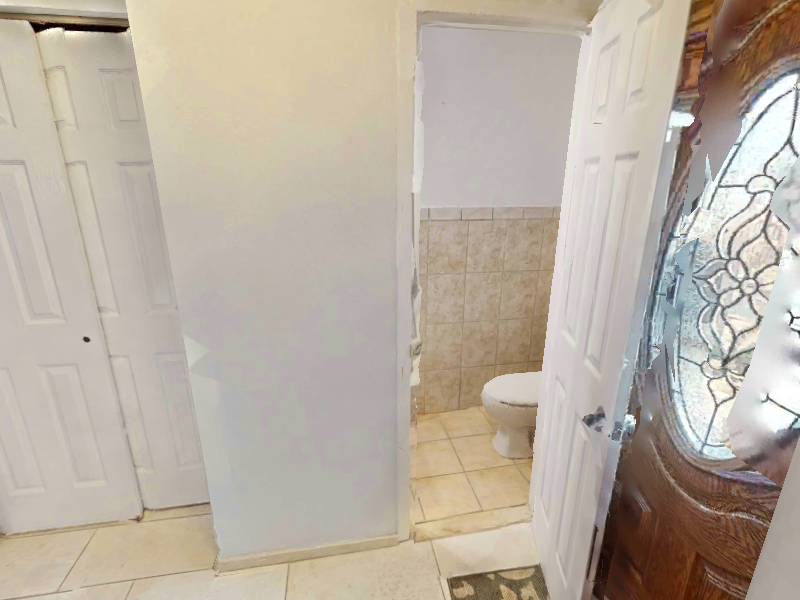

tensor([4])
bathroom
tensor([0.96236], grad_fn=<MaxBackward0>)


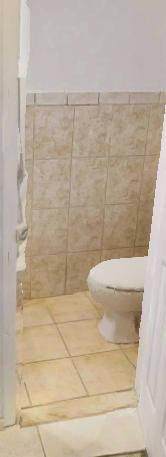

tensor([4])
bathroom
tensor([0.97956], grad_fn=<MaxBackward0>)


In [26]:
import shutil
import glob
imagePath="/content/drive/MyDrive/DeepLearning/SceneClassification/437.png"
file_paths=[]
resul=DoorDetector2(imagePath)
resul.crop(save=True,save_dir="/content/drive/MyDrive/DeepLearning/SceneClassification/Images2")
predict(imagePath)
if os.path.exists("/content/drive/MyDrive/DeepLearning/SceneClassification/Images2/crops/2"):
        file_paths +=glob.glob("/content/drive/MyDrive/DeepLearning/SceneClassification/Images2/crops/2"+"/*")
        for path in file_paths:
                im1 =Image.open(path)
                width,height=im1.size
                im1=im1.crop((20,20,width-20,height))
                im1.save("im2.jpeg")
                predict("im2.jpeg")
                os.remove("im2.jpeg")
else:
        print("No Multiple Scenes")
shutil.rmtree("/content/drive/MyDrive/DeepLearning/SceneClassification/Images2")

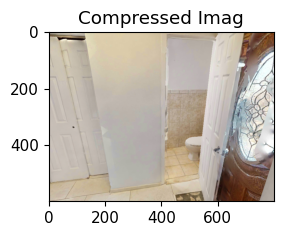

In [32]:
%matplotlib inline
import cv2
from PIL import Image
import matplotlib.pyplot as plt




img = Image.open(imagePath).convert('RGB')

# ax = plt.subplot(1, 2, 1)
plt.title("Compressed Imag")

plt.imshow(img)
plt.show()